In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime as dt
from datetime import timedelta as td

In [2]:
import utils

In [3]:
RAW_ROOT = 'raw'
DATA_ROOT = 'data'

In [4]:
_, _, _, df_sub_raw = utils.load_raw(RAW_ROOT)

In [5]:
df_user_CV = pd.read_parquet(f'{DATA_ROOT}/df_user_aggregated_CV.pq')
df_user_LB = pd.read_parquet(f'{DATA_ROOT}/df_user_aggregated_LB.pq')
df_item_CV = pd.read_parquet(f'{DATA_ROOT}/df_item_aggregated_CV.pq')
df_item_LB = pd.read_parquet(f'{DATA_ROOT}/df_item_aggregated_LB.pq')
df_log_all = pd.read_parquet(f'{DATA_ROOT}/df_log_preprocessed.pq')
df_log_CV = utils.get_df_log_of(df_log_all, 'CV')
df_log_LB = utils.get_df_log_of(df_log_all, 'LB')

del df_log_all

# submit test

In [6]:
df_log_CV_test = df_log_CV[df_log_CV['target'] == 'test']
df_log_CV_train_valid = df_log_CV[df_log_CV['target'] != 'test']

uid2aiidset_CV = {}
for row in df_log_CV_test[['customer_id', 'article_id']].itertuples():
    _, uid, iid = row
    if uid not in uid2aiidset_CV:
        uid2aiidset_CV[uid] = set()
    uid2aiidset_CV[uid].add(iid)

df_iid_count_temp = df_log_CV_train_valid[['article_id', 'customer_id']].groupby('article_id').count()
df_iid_count_temp.columns = ['count']

global_popular_iids = list(df_iid_count_temp.sort_values('count', ascending=False).iloc[:12].index)

APs = []
for uid, aiidset in uid2aiidset_CV.items():
    AP = utils.calc_ap(aiidset, global_popular_iids)
    APs.append(AP)
mAP = np.array(APs).mean()

print(f"POP_CV: {100 * mAP:.04f}%")

del APs
del global_popular_iids
del df_iid_count_temp

POP_CV: 0.5275%


In [7]:
os.makedirs('data/subs', exist_ok=True)

In [9]:
df_iid_count_temp = df_log_LB[['article_id', 'customer_id']].groupby('article_id').count()
df_iid_count_temp.columns = ['count']

global_popular_iids = list(df_iid_count_temp.sort_values('count', ascending=False).iloc[:12].index)

sub_name = 'POP'

df_sub_temp = df_sub_raw.copy()
df_sub_temp['prediction'] = ' '.join(global_popular_iids)
df_sub_temp.to_csv(f'data/subs/{sub_name}_LB.csv.gz', index=False)

# submit to kaggle

del df_sub_temp
del global_popular_iids
del df_iid_count_temp

# recent week popular

In [10]:
last_week = df_log_CV_train_valid['week'].max()

week_cuts = list(range(1, last_week + 2))

results = []
for week_cut in week_cuts:
    df_log_temp = df_log_CV_train_valid[df_log_CV_train_valid['week'] > last_week - week_cut]
    df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
    df_iid_count_temp.columns = ['count']
    local_popular_iids = list(df_iid_count_temp.sort_values('count', ascending=False).iloc[:12].index)
    APs = []
    for uid, aiidset in uid2aiidset_CV.items():
        AP = utils.calc_ap(aiidset, local_popular_iids)
        APs.append(AP)
    mAP = np.array(APs).mean()
    results.append((week_cut, mAP))

del APs
del local_popular_iids
del df_iid_count_temp
del df_log_temp

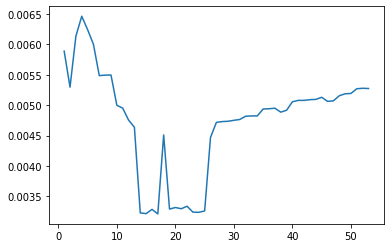

In [11]:
plt.plot(week_cuts, [mAP for _, mAP in results])

In [12]:
best_week_cut, mAP = sorted(results, key=lambda x: x[1], reverse=True)[0]
print(f"RWP_WC{best_week_cut}_CV: {100 * mAP:.04f}%")

RWP_WC4_CV: 0.6464%


In [13]:
last_week = df_log_LB['week'].max()

df_log_temp = df_log_LB[df_log_LB['week'] > last_week - best_week_cut]
df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
df_iid_count_temp.columns = ['count']
local_popular_iids = list(df_iid_count_temp.sort_values('count', ascending=False).iloc[:12].index)

sub_name = f'RWP_WC{best_week_cut}'

df_sub_temp = df_sub_raw.copy()
df_sub_temp['prediction'] = ' '.join(local_popular_iids)
df_sub_temp.to_csv(f'data/subs/{sub_name}_LB.csv.gz', index=False)

del df_sub_temp
del local_popular_iids
del df_iid_count_temp
del df_log_temp

# ascending week popular

In [14]:
last_week = df_log_CV_train_valid['week'].max()
min_week = df_log_CV_train_valid['week'].min()

df_item_temp = df_item_CV.copy()
for week in list(range(last_week + 1)):
    df_log_temp = df_log_CV_train_valid[df_log_CV_train_valid['week'] == week]
    df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
    df_iid_count_temp.columns = [f'week_{week}_count']
    df_item_temp = df_item_temp.merge(df_iid_count_temp, how='left', left_index=True, right_index=True)
    df_item_temp[f'week_{week}_count'].fillna(0, inplace=True)

def ascender(weight, power, ss):
    return np.power(weight, power) * ss

week_cuts = list(range(2, last_week - min_week + 2))

powers = [i / 10 for i in range(1, 10)] + [i / 2 for i in range(2, 20)] + [i * 10 for i in range(1, 6)] + [100]
powers = [float(power) for power in powers]

results = []
for week_cut in week_cuts:
    mAPs = []
    for power in powers:
        df_item_temp['awp'] = 0
        start_week = last_week - week_cut + 1
        for week in range(start_week, last_week + 1):
            weight = (week - start_week + 1) / (last_week - start_week + 2)
            df_item_temp['awp'] += ascender(weight, power, df_item_temp[f'week_{week}_count'])
        ascending_popular_iids = list(df_item_temp['awp'].sort_values(ascending=False).iloc[:12].index)
        APs = []
        for uid, aiidset in uid2aiidset_CV.items():
            AP = utils.calc_ap(aiidset, ascending_popular_iids)
            APs.append(AP)
        mAP = np.array(APs).mean()
        mAPs.append(mAP)
    best_power_index = np.argsort(mAPs)[::-1][0]
    results.append((best_power_index, mAPs[best_power_index]))

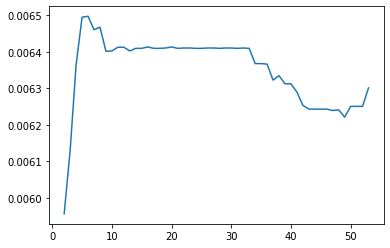

In [15]:
plt.plot(week_cuts, [mAP for _, mAP in results])

In [16]:
best_week_cut_index = np.argsort([mAP for _, mAP in results])[-1]
best_power_index, mAP = results[best_week_cut_index]
best_week_cut = week_cuts[best_week_cut_index]
best_power = powers[best_power_index]

print(f"AWP_WC{best_week_cut}_P{best_power}_CV: {100 * mAP:.04f}%")

del results
del APs
del mAPs
del ascending_popular_iids

del df_item_temp
del df_log_temp
del df_iid_count_temp

AWP_WC6_P0.8_CV: 0.6497%


In [17]:
last_week = df_log_LB['week'].max()

start_week = last_week - best_week_cut + 1

df_item_temp = df_item_LB.copy()
for week in range(start_week, last_week + 1):
    df_log_temp = df_log_LB[df_log_LB['week'] == week]
    df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
    df_iid_count_temp.columns = [f'week_{week}_count']
    df_item_temp = df_item_temp.merge(df_iid_count_temp, how='left', left_index=True, right_index=True)
    df_item_temp[f'week_{week}_count'].fillna(0, inplace=True)

df_item_temp['awp'] = 0
for week in range(start_week, last_week + 1):
    weight = (week - min_week + 1) / (last_week - min_week + 2)
    df_item_temp['awp'] += ascender(weight, power, df_item_temp[f'week_{week}_count'])
ascending_popular_iids = list(df_item_temp['awp'].sort_values(ascending=False).iloc[:12].index)

sub_name = f'AWP_WC{best_week_cut}_P{best_power}'

df_sub_temp = df_sub_raw.copy()
df_sub_temp['prediction'] = ' '.join(ascending_popular_iids)
df_sub_temp.to_csv(f'data/subs/{sub_name}_LB.csv.gz', index=False)

del df_sub_temp
del ascending_popular_iids

del df_item_temp
del df_iid_count_temp
del df_log_temp

# recent bought

In [18]:
best_week_cut = 4

last_week = df_log_CV_train_valid['week'].max()

df_log_temp = df_log_CV_train_valid[df_log_CV_train_valid['week'] > last_week - best_week_cut]
df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
df_iid_count_temp.columns = ['count']
local_popular_iids = list(df_iid_count_temp.sort_values('count', ascending=False).iloc[:12].index)

del df_iid_count_temp
del df_log_temp

In [19]:
max_week_cut = 20
week_cuts = list(range(1, max_week_cut + 1))

results = []
for week_cut in list(range(1, max_week_cut + 1)):
    df_log_temp = df_log_CV_train_valid[df_log_CV_train_valid['week'] > (last_week - week_cut)]
    df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
    df_iid_count_temp.columns = ['count']
    df_log_temp = df_log_temp.merge(df_iid_count_temp, how='left', left_on='article_id', right_index=True)
    df_log_temp = df_log_temp.sort_values(['t_dat', 'count'], ascending=[False, False])
    df_recent_boughts = df_log_temp.groupby('customer_id').agg({'article_id': lambda x: list(x)[:12]})
    df_recent_boughts.columns = ['recent_boughts']
    APs = []
    for uid, aiidset in uid2aiidset_CV.items():
        predictions = []
        try:
            recent_bought_iids = df_recent_boughts.loc[uid, 'recent_boughts']
        except KeyError:
            recent_bought_iids = []
        for iid in recent_bought_iids:
            if iid in predictions:
                continue
            predictions.append(iid)
        for iid in local_popular_iids:
            if iid in predictions:
                continue
            predictions.append(iid)
        AP = utils.calc_ap(aiidset, predictions[:12])
        APs.append(AP)
    mAP = np.array(APs).mean()
    results.append((week_cut, mAP))

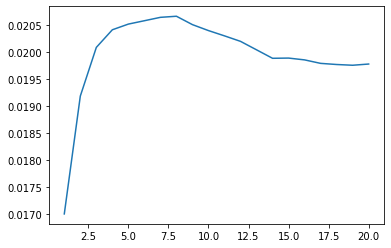

In [20]:
plt.plot(week_cuts, [mAP for _, mAP in results])

In [21]:
week_cut, mAP = sorted(results, key=lambda x: x[1], reverse=True)[0]
print(f"RB_WC{week_cut}_CV: {100 * mAP:.04f}%")

del results
del APs
del df_recent_boughts
del recent_bought_iids
del local_popular_iids

del df_iid_count_temp
del df_log_temp

RB_WC8_CV: 2.0657%


In [22]:
best_week_cut = 4

last_week = df_log_LB['week'].max()

df_log_temp = df_log_LB[df_log_LB['week'] > last_week - best_week_cut]
df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
df_iid_count_temp.columns = ['count']
local_popular_iids = list(df_iid_count_temp.sort_values('count', ascending=False).iloc[:12].index)

del df_iid_count_temp
del df_log_temp

In [23]:
df_log_temp = df_log_LB[df_log_LB['week'] > (last_week - week_cut)]
df_iid_count_temp = df_log_temp[['article_id', 'customer_id']].groupby('article_id').count()
df_iid_count_temp.columns = ['count']
df_log_temp = df_log_temp.merge(df_iid_count_temp, how='left', left_on='article_id', right_index=True)
df_log_temp = df_log_temp.sort_values(['t_dat', 'count'], ascending=[False, False])
df_recent_boughts = df_log_temp.groupby('customer_id').agg({'article_id': lambda x: list(x)[:12]})
df_recent_boughts.columns = ['recent_boughts']

df_sub_temp = df_sub_raw.copy()

sub_rows = []
uids = df_sub_temp['customer_id'].to_list()
for uid in uids:
    predictions = []
    try:
        recent_bought_iids = df_recent_boughts.loc[uid, 'recent_boughts']
    except KeyError:
        recent_bought_iids = []
    for iid in recent_bought_iids:
        if iid in predictions:
            continue
        predictions.append(iid)
    for iid in local_popular_iids:
        if iid in predictions:
            continue
        predictions.append(iid)
    sub_rows.append((uid, ' '.join(predictions[:12])))

sub_name = f'RB_WD{week_cut}'

df_sub_temp = pd.DataFrame(sub_rows)
df_sub_temp.columns = ['customer_id', 'prediction']
df_sub_temp.to_csv(f'data/subs/{sub_name}_LB.csv.gz', index=False)

del df_recent_boughts
del recent_bought_iids
del local_popular_iids

del df_iid_count_temp
del df_log_temp